In [2]:
import time
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import polars as pl 
import json

from decoding_strategies_over_custom_gpt import GenerativeModel
from gpt import CharTokenizer

In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
tokenizer = CharTokenizer()

with open("data/tokenizer_vocab.json", "r", encoding="utf-8") as f:
    raw_vocab = json.load(f)
    tokenizer._vocab = {int(k): v for k, v in raw_vocab.items()}

In [5]:
VOCAB_SIZE = len(tokenizer.vocab)
BATCH_SIZE = 1024
MAX_SEQ_LEN = 200
N_LAYERS = 6
EMBEDDING_SIZE = 128
NUM_HEADS = 8
NUM_KV_GROUPS = 2
NUM_EXPERTS = 16
NUM_EXPERTS_PER_TOKEN = 2
HEAD_EMBEDDING_SIZE = EMBEDDING_SIZE // NUM_HEADS
FCCN_HIDDEN_SIZE = EMBEDDING_SIZE * 4
n_epoch = 20

In [6]:
model_config = dict(
    vocab_size=VOCAB_SIZE,
    n_layers=N_LAYERS,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_kv_groups=NUM_KV_GROUPS,
    num_experts=NUM_EXPERTS,
    num_experts_per_token=NUM_EXPERTS_PER_TOKEN,
    head_embedding_size=HEAD_EMBEDDING_SIZE,
    fcnn_hidden_size=FCCN_HIDDEN_SIZE,
    dropout=0.15,
)

generator = GenerativeModel(**model_config)

generator.load_state_dict(torch.load("data/my_gpt_weights.pt", map_location=device))

generator.to(device)
generator.eval()

GenerativeModel(
  (_decoder): Decoder(
    (_embeddings): Embedding(75, 128, padding_idx=0)
    (_positional_embedding): RotaryPositionEmbedding()
    (_layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (_mha): GroupedQueryAttention(
          (_positional_embedding): RotaryPositionEmbedding()
          (_Q): Linear(in_features=128, out_features=128, bias=True)
          (_K): Linear(in_features=128, out_features=32, bias=True)
          (_V): Linear(in_features=128, out_features=32, bias=True)
          (_W_proj): Linear(in_features=128, out_features=128, bias=True)
          (_q_norm): RMSNorm()
          (_k_norm): RMSNorm()
        )
        (_fcnn): MoEFeedForward(
          (_gate): Linear(in_features=128, out_features=16, bias=False)
          (_fc1): ModuleList(
            (0-15): 16 x Linear(in_features=128, out_features=512, bias=False)
          )
          (_fc2): ModuleList(
            (0-15): 16 x Linear(in_features=128, out_features=512, bias=False)
        

In [7]:
def benchmark_parameter(param_name, param_values, prompt, fixed_params):
    """
    Generates text changing one param
    """
    results = []
    
    print(f"\nTesting param: {param_name}")
    
    for val in tqdm(param_values):
        current_params = fixed_params.copy()
        current_params[param_name] = val
        
        start_time = time.time()
        
        output_text = generator.generate(
            text_input=prompt, 
            tokenizer=tokenizer, 
            device=device, 
            **current_params
        )
        
        end_time = time.time()
        
        results.append({
            "Parameter": param_name,
            "Value": val,
            "Time (sec)": round(end_time - start_time, 4),
            "Output": output_text,
            "Length (chars)": len(output_text)
        })
        
    return pd.DataFrame(results)

def plot_results(df, title):
    """
    Plot text length and time generation taken graphs
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # TIME TAKEN
    sns.barplot(data=df, x='Value', y='Time (sec)', ax=axes[0], palette='viridis')
    axes[0].set_title(f'Time dependence on {df["Parameter"].iloc[0]}')
    axes[0].set_xlabel(df["Parameter"].iloc[0])
    
    # TEXT LEN
    sns.lineplot(data=df, x='Value', y='Length (chars)', ax=axes[1], marker='o', color='red')
    axes[1].set_title(f'Output length dependence on {df["Parameter"].iloc[0]}')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    # TABLE
    display(df[['Value', 'Time (sec)', 'Output']])

In [8]:
results = []
common_prompt = "Geralt "

## Beam Search
 do_sample=False -> Deterministic Beam Search

In [9]:
base_params_beam = {
    "max_new_tokens": 40,
    "repetition_penalty": 1.0,
    "temperature": 1.0,
    "top_k": 50,
    "top_p": 0.9,
    "do_sample": False  
}

beam_values = [1, 2, 4, 8]

df_beams = benchmark_parameter("num_beams", beam_values, common_prompt, base_params_beam)


Testing param: num_beams


  0%|          | 0/4 [00:00<?, ?it/s]

Starting Sampling decoding.
Strategy: Greedy
Strategy: Greedy
Strategy: Greedy
Strategy: Greedy
Strategy: Greedy
Strategy: Greedy
Strategy: Greedy
Strategy: Greedy
Strategy: Greedy
Strategy: Greedy
Strategy: Greedy


 25%|██▌       | 1/4 [00:00<00:01,  2.23it/s]

Strategy: Greedy
Starting Beam Search decoding.
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Determ

 50%|█████     | 2/4 [00:03<00:03,  1.98s/it]

Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Starting Beam Search decoding.
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Sear

 75%|███████▌  | 3/4 [00:09<00:03,  3.75s/it]

Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Starting Beam Search decoding.
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Sear

100%|██████████| 4/4 [00:21<00:00,  5.47s/it]

Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search
Strategy: Deterministic Beam Search


In [11]:
df_beams

,Parameter,Value,Time (sec),Output,Length (chars)
0,num_beams,1,0.4493,Курочинская,12
1,num_beams,2,3.0548,Балашов,8
2,num_beams,4,5.8620,Марков,7
3,num_beams,8,12.5081,Беренцев,9


OptionError: No such keys(s): 'mode.use_inf_as_null'

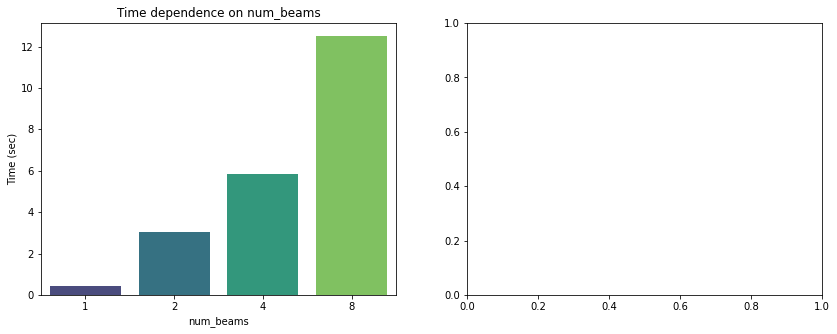

In [10]:
plot_results(df_beams, "Influence of num_beams (Beam Search)")

## Temperature (sampling)
do_sample=True, num_beams=1 -> Sampling

In [ ]:
base_params_temp = {
    "max_new_tokens": 50,
    "num_beams": 1,
    "top_k": 0,
    "top_p": 0.0,
    "repetition_penalty": 1.0,
    "do_sample": True 
}

temp_values = [0.1, 0.5, 0.8, 1.0, 1.5, 3.0]

df_temp = benchmark_parameter("temperature", temp_values, common_prompt, base_params_temp)

In [ ]:
plot_results(df_temp, "Influence of temperature (Sampling)")

## Top-K

In [ ]:
base_params_k = {
    "max_new_tokens": 40,
    "num_beams": 1,
    "temperature": 1.0,
    "top_p": 0.0,
    "repetition_penalty": 1.0,
    "do_sample": True
}

k_values = [1, 5, 20, 50, 0]

df_k = benchmark_parameter("top_k", k_values, common_prompt, base_params_k)

In [ ]:
plot_results(df_k, "Influence of top_k")

## Repetition penalty

In [ ]:
loop_prompt = "Geralt of Rivia is a witcher and Geralt of Rivia"
base_params_rep = {
    "max_new_tokens": 50,
    "num_beams": 1,
    "temperature": 1.0,
    "do_sample": False, # Greedy search
    "top_k": 50,
    "top_p": 0.9,
}

penalty_values = [1.0, 1.05, 1.1, 1.2, 2.0]

df_rep = benchmark_parameter("repetition_penalty", penalty_values, loop_prompt, base_params_rep)

In [ ]:
plot_results(df_rep, "Influence of repetition_penalty")

## Comparison

In [ ]:
comparison_data = [
    {"Strategy": "Greedy", "Time": df_beams[df_beams['Value'] == 1]['Time (sec)'].values[0]},
    {"Strategy": "Beam Search (k=4)", "Time": df_beams[df_beams['Value'] == 4]['Time (sec)'].values[0]},
    {"Strategy": "Beam Search (k=8)", "Time": df_beams[df_beams['Value'] == 8]['Time (sec)'].values[0]},
    {"Strategy": "Sampling", "Time": df_temp[df_temp['Value'] == 1.0]['Time (sec)'].values[0]},
]

df_comp = pd.DataFrame(comparison_data)

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_comp, x='Strategy', y='Time', palette='magma')
plt.title('Comparison of generation speed')
plt.ylabel('Time (sec)')
plt.xticks(rotation=45)
plt.show()